<h2 style='color:red'>Dataset Preparation and Preprocessing</h2>
<p>You must corrupt the high-quality (HQ) images on the fly during training to create low-quality (LQ) counterparts, simulating the conditions expected in the test set. This involves applying a second-order degradation pipeline consisting of Gaussian blur, downsampling, noise, and compression.</p>
<h3 style='color:red'>Degradation Pipeline Example:</h3>

In [14]:
import os
import io
import torch
import numpy as np
from PIL import Image, ImageFilter
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
def validate_image_np(image_np):
    if image_np.size == 0:
        raise ValueError("Image is empty.")
    if image_np.dtype != np.uint8:
        raise ValueError("Image data type must be np.uint8.")
    if len(image_np.shape) != 3 or image_np.shape[2] not in [1, 3, 4]:
        raise ValueError("Image must be in HxWxC format with 1, 3, or 4 channels.")


def apply_gaussian_blur(image_np):
    kernel_size = np.random.choice([7, 9, 11, 13, 15, 17, 19, 21])
    sigma = np.random.uniform(0.2, 3)
    blurred_image_np = cv2.GaussianBlur(image_np, (kernel_size, kernel_size), sigma)
    return blurred_image_np

def apply_downsampling(image_np, target_size=(128, 128)):
    """
    Downsamples an image to a target size.
    """
    downsampled_image_np = cv2.resize(image_np, target_size, interpolation=cv2.INTER_LINEAR)
    return downsampled_image_np


def apply_noise(image_np, noise_type='gaussian', noise_level=15):
    if noise_type == 'gaussian':
        row, col, ch = image_np.shape
        mean = 0
        sigma = noise_level ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        noisy_image_np = image_np + gauss
        return np.clip(noisy_image_np, 0, 255).astype('uint8')

    elif noise_type == 'salt_pepper':
        s_vs_p = 0.5  # Ratio of salt vs. pepper noise
        amount = noise_level / 100
        out = np.copy(image_np)

        # Salt noise
        num_salt = np.ceil(amount * image_np.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image_np.shape]
        out[coords[0], coords[1], :] = 1

        # Pepper noise
        num_pepper = np.ceil(amount * image_np.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image_np.shape]
        out[coords[0], coords[1], :] = 0

        return out


def apply_compression(image_np):
    # Validate the image
    validate_image_np(image_np)

    # Ensure image is in correct format for OpenCV (convert to BGR if necessary)
    if image_np.shape[2] == 3:  # Convert RGB to BGR for OpenCV if it's a 3-channel image
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    quality = int(np.random.uniform(5, 50))
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, encimg = cv2.imencode('.jpg', image_np, encode_param)
    if not success:
        raise RuntimeError("Failed to encode image.")

    image_np = cv2.imdecode(encimg, cv2.IMREAD_UNCHANGED)

    # Convert back to RGB if needed
    if image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    return image_np

def second_order_degradation(image):
    """
    Applies a series of degradations to simulate a low-quality image.
    Assumes input is a high-quality PIL image.
    """
    image_np = np.array(image)
    image_np = apply_gaussian_blur(image_np)
    image_np = apply_downsampling(image_np, target_size=(128, 128))  # Downsampling to 128x128
    image_np = apply_noise(image_np, noise_type='gaussian')
    image_np = apply_compression(image_np)
    return Image.fromarray(image_np)

class FaceDataset(Dataset):
    def __init__(self, root_dir_gt, root_dir_lq=None,transform_lq=None, transform_hq=None, mode='train'):
        """
        Args:
            root_dir_gt (string): Directory with all the high-quality images.
            root_dir_lq (string): Optional directory with all the low-quality images for validation.
            transform (callable, optional): Optional transform to be applied on a sample.
            mode (string): Indicate whether the dataset is used for 'train' or 'val'.
        """
        self.root_dir_gt = root_dir_gt
        self.root_dir_lq = root_dir_lq
        self.transform_lq = transform_lq
        self.transform_hq = transform_hq
        self.mode = mode
        self.image_filenames_gt = [os.path.join(root_dir_gt, fname) for fname in os.listdir(root_dir_gt)]
        if root_dir_lq:
            self.image_filenames_lq = [os.path.join(root_dir_lq, fname) for fname in os.listdir(root_dir_lq)]
        else:
            self.image_filenames_lq = []

    def __len__(self):
        return len(self.image_filenames_gt)

    def __getitem__(self, idx):
        img_name_gt = self.image_filenames_gt[idx]
        hq_image = Image.open(img_name_gt).convert('RGB')

        if self.mode == 'train':
            lq_image = second_order_degradation(hq_image)
        else:
            img_name_lq = self.image_filenames_lq[idx]
            lq_image = Image.open(img_name_lq).convert('RGB')

        if self.transform_hq:
            hq_image = self.transform_hq(hq_image)
        if self.transform_lq:
            lq_image = self.transform_lq(lq_image)

        return lq_image, hq_image, os.path.basename(img_name_gt)


# Define the transformation
hq_transform = transforms.Compose([
    transforms.Resize((512, 512)),      # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to tensor

])

lq_transform = transforms.Compose([
    transforms.Resize((128, 128)),      # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to tensor
  
])
# Training dataset and dataloader
train_dataset = FaceDataset(
    root_dir_gt='/kaggle/input/super-resolution-dataset/datasets_original/train/GT',
    root_dir_lq=None,  # Indicate dynamic generation or simply not use for training
    transform_lq=lq_transform,  # Correct argument name
    transform_hq=hq_transform,  # Correct argument name
    mode='train'
)

val_dataset = FaceDataset(
    root_dir_gt='/kaggle/input/super-resolution-dataset/datasets_original/val/GT',
    root_dir_lq='/kaggle/input/super-resolution-dataset/datasets_original/val/LQ',
    transform_lq=lq_transform,  # Correct argument name
    transform_hq=hq_transform,  # Correct argument name
    mode='val'
)


train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# Print the length of the dataset
print(f"Dataset contains {len(train_dataset)} HQ images.")
print(f"Dataset contains {len(val_dataset)} LQ images.")


Dataset contains 5000 HQ images.
Dataset contains 400 LQ images.


TRAINING IMAGES (HQ and degraded images on the fly)

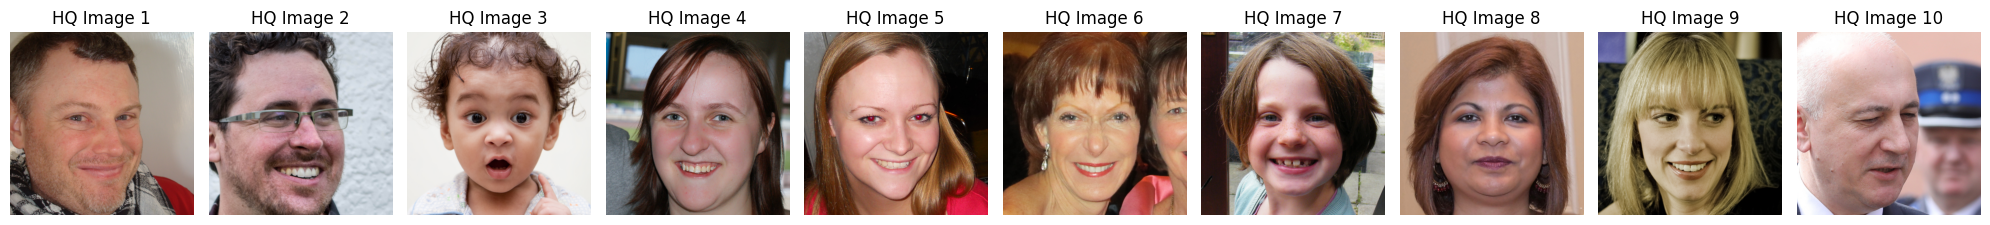

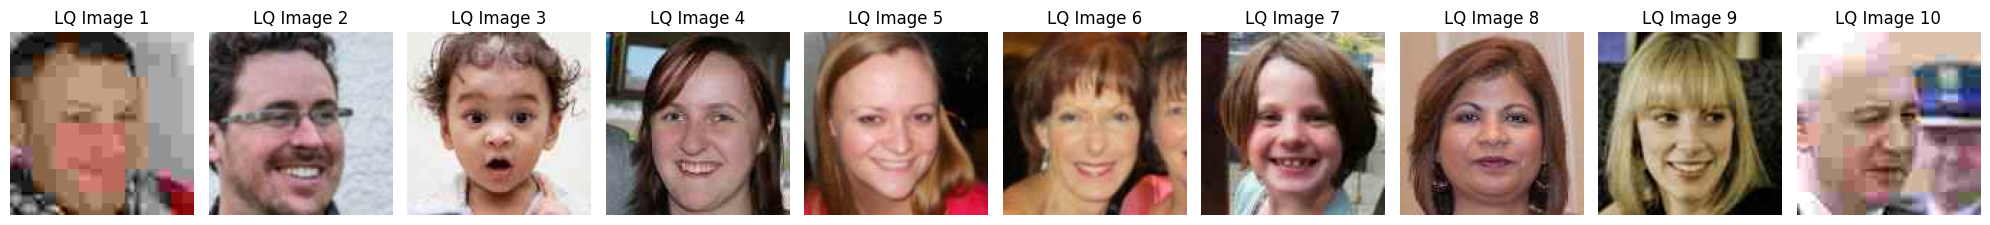

In [15]:
import matplotlib.pyplot as plt
def show_images(images, titles, ncols=10, nrows=2, figsize=(20, 5)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()  # Flatten the axes array

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and display 10 HQ and 10 LQ images
hq_images = []
lq_images = []
hq_titles = []
lq_titles = []

# Use the previously defined dataset to get HQ and LQ images and their paths
for i in range(10):
    lq_image, hq_image, _ = train_dataset[i]  # These are already tensors if your transform includes ToTensor
    hq_images.append(TF.to_pil_image(hq_image.cpu()))  # Convert tensors to PIL images for display
    hq_titles.append(f"HQ Image {i+1}")
    lq_images.append(TF.to_pil_image(lq_image.cpu()))  # Convert tensors to PIL images for display
    lq_titles.append(f"LQ Image {i+1}")

# Plot HQ images
show_images(hq_images, hq_titles, ncols=10, nrows=1, figsize=(20, 5))

# Plot LQ images
show_images(lq_images, lq_titles, ncols=10, nrows=1, figsize=(20, 5))


Validation Images (HQ and LQ)

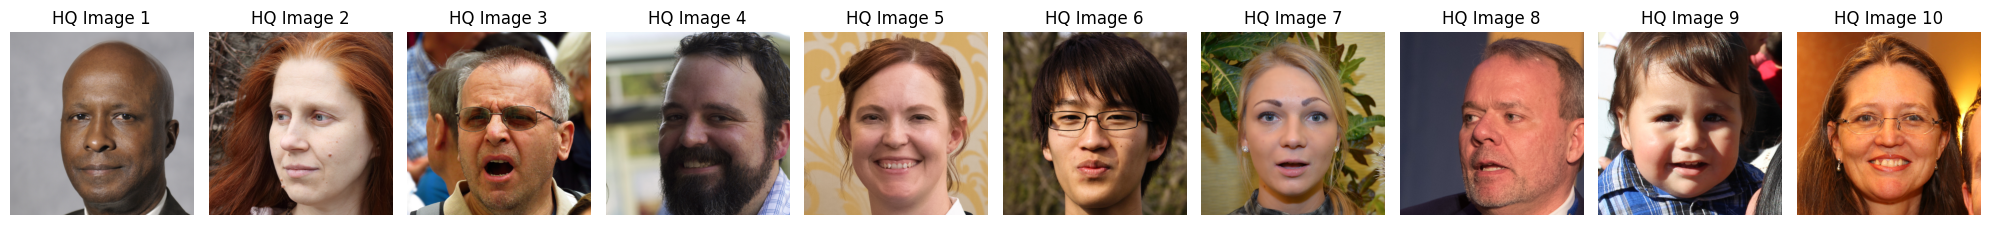

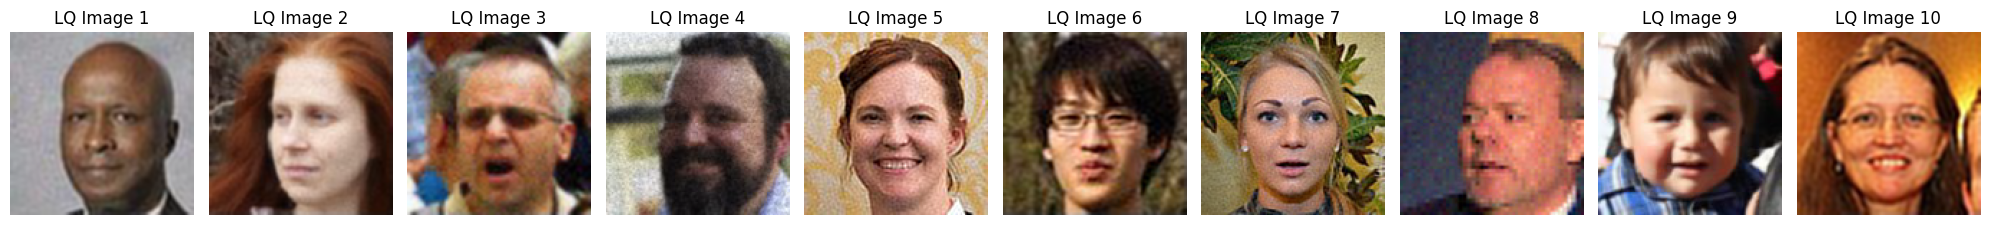

In [16]:
import matplotlib.pyplot as plt
def show_images(images, titles, ncols=10, nrows=2, figsize=(20, 5)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()  # Flatten the axes array

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Load and display 10 HQ and 10 LQ images
hq_images = []
lq_images = []
hq_titles = []
lq_titles = []

# Use the previously defined dataset to get HQ and LQ images and their paths
for i in range(10):
    lq_image, hq_image, _ = val_dataset[i]  # These are already tensors if your transform includes ToTensor
    hq_images.append(TF.to_pil_image(hq_image.cpu()))  # Convert tensors to PIL images for display
    hq_titles.append(f"HQ Image {i+1}")
    lq_images.append(TF.to_pil_image(lq_image.cpu()))  # Convert tensors to PIL images for display
    lq_titles.append(f"LQ Image {i+1}")

# Plot HQ images
show_images(hq_images, hq_titles, ncols=10, nrows=1, figsize=(20, 5))

# Plot LQ images
show_images(lq_images, lq_titles, ncols=10, nrows=1, figsize=(20, 5))


Using Python Files in Jupyter Notebooks:

    Importing Python Files: You can import .py files into your Jupyter Notebook (ipynb) just like any other Python module.


<h2 style='color:red'>Model Architecture</h2>

You are encouraged to use SRResNet as a baseline for the super-resolution task but with a limitation on the number of trainable parameters (not more than 2276356 parameters).
<h3 style='color:red'>Model Definition (SRResNet):</h3>

Paper https://sh-tsang.medium.com/review-srgan-srresnet-photo-realistic-super-resolution-gan-super-resolution-96a6fa19490

In [17]:
!pip install basicsr

In [18]:
from basicsr.archs.srresnet_arch import MSRResNet
from basicsr.archs.discriminator_arch import UNetDiscriminatorSN

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

generator = MSRResNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=16, upscale=4)
discriminator = UNetDiscriminatorSN(num_in_ch=3, num_feat=32)

total_params_Generator = count_parameters(generator)
total_params_Discriminator =count_parameters(discriminator)
print(f'Parameters for Generator are: {total_params_Generator} \n Parameters for Discriminator are: {total_params_Discriminator}')

Parameters for Generator are: 1517571 
 Parameters for Discriminator are: 1094817


In [19]:
!nvidia-smi

Thu Apr 25 13:05:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              32W / 250W |   2796MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Run all 20 epochs for checking. Now I used 5 for showing you that codes are error free.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

from tqdm import tqdm

output_dir = "/kaggle/working/"

# Create a subfolder for LQ images within the output directory
lq_image_dir = os.path.join(output_dir, "LQ_images")
os.makedirs(lq_image_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")
# Instantiate the generator and discriminator
generator = generator.to(device)
discriminator = discriminator.to(device)

# Define loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_content = nn.L1Loss()

# Define optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002,weight_decay=1e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002,weight_decay=1e-5)

# Function to calculate PSNR
def calculate_psnr(pred, gt):
    mse = F.mse_loss(pred, gt, reduction="mean")
    max_i = 1.0
    psnr = 20 * torch.log10(max_i / torch.sqrt(mse))
    return psnr.item()

# Plot Loss PSNR
train_losses_G = []
train_losses_D = []
train_psnrs = []
val_losses = []
val_psnrs = []


# Set the interval for saving images
save_interval = 5

# Training loop parameters
num_epochs = 20
accumulation_steps = 4  # How many steps to accumulate gradients for

best_val_loss = float("inf")

for epoch in range(num_epochs):
    generator.train()
    train_loss_total = 0.0
    train_psnr_total = 0.0
    train_loss_D_total = 0.0

    for batch_index, (lq_images, hq_images,_) in tqdm(enumerate(train_dataloader), desc="Training"):
        hq_images, lq_images = hq_images.to(device), lq_images.to(device)

        # Reset gradients on accumulation steps
        if batch_index % accumulation_steps == 0:
            optimizer_D.zero_grad()
            optimizer_G.zero_grad()

        fake_images = generator(lq_images)
        loss_G_content = criterion_content(fake_images, hq_images)
        loss_G = loss_G_content
        (loss_G / accumulation_steps).backward()  # Scale loss
        train_loss_total += loss_G.item()
        psnr = calculate_psnr(fake_images, hq_images)
        train_psnr_total += psnr

        # Perform optimization steps at specified intervals
        if (batch_index + 1) % accumulation_steps == 0 or (batch_index + 1) == len(train_dataloader):
            optimizer_D.step()
            optimizer_G.step()

    # Average metrics for the epoch
    avg_train_loss = train_loss_total / len(train_dataloader)
    avg_train_psnr = train_psnr_total / len(train_dataloader)
    avg_train_loss_D = train_loss_D_total / len(train_dataloader)
    
    # Inside the training loop
    train_losses_G.append(avg_train_loss)
    train_psnrs.append(avg_train_psnr)
    train_losses_D.append(avg_train_loss_D)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss G: {avg_train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f}")
    #print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss G: {avg_train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f}, Train Loss D: {avg_train_loss_D:.4f}")

# Saving Model After Validation
    generator.eval()
    val_loss_total = 0.0
    val_psnr_total = 0.0

    with torch.no_grad():
        for i, (lq_images, hq_images, _) in enumerate(val_dataloader):
            lq_images, hq_images = lq_images.to(device), hq_images.to(device)
            output = generator(lq_images)
            val_loss = criterion_content(output, hq_images)  # Assuming validation loss is content loss
            val_loss_total += val_loss.item()
            psnr = calculate_psnr(output, hq_images)
            val_psnr_total += psnr

    avg_val_loss = val_loss_total / len(val_dataloader)
    avg_val_psnr = val_psnr_total / len(val_dataloader)
    
    # Inside the validation loop
    val_losses.append(avg_val_loss)
    val_psnrs.append(avg_val_psnr)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation PSNR: {avg_val_psnr:.2f}")

    # Save the model if it has the best validation loss so far
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print("Saving best model...")
        torch.save(generator.state_dict(), os.path.join(output_dir, 'best_generator.pth'))
        torch.save(discriminator.state_dict(), os.path.join(output_dir, 'best_discriminator.pth'))

Training on device: cuda


Training: 1250it [02:50,  7.33it/s]

Epoch [1/5], Train Loss G: 0.0322, Train PSNR: 26.09


Epoch [1/5], Validation Loss: 0.0349, Validation PSNR: 25.41
Saving best model...


Training: 1250it [02:50,  7.32it/s]

Epoch [2/5], Train Loss G: 0.0313, Train PSNR: 26.25


Epoch [2/5], Validation Loss: 0.0347, Validation PSNR: 25.44
Saving best model...


Training: 1250it [02:50,  7.33it/s]

Epoch [3/5], Train Loss G: 0.0310, Train PSNR: 26.32


Epoch [3/5], Validation Loss: 0.0344, Validation PSNR: 25.46
Saving best model...


Training: 1250it [02:50,  7.32it/s]

Epoch [4/5], Train Loss G: 0.0308, Train PSNR: 26.36


Epoch [4/5], Validation Loss: 0.0341, Validation PSNR: 25.51
Saving best model...


Training: 1250it [02:50,  7.33it/s]

Epoch [5/5], Train Loss G: 0.0307, Train PSNR: 26.37


Epoch [5/5], Validation Loss: 0.0340, Validation PSNR: 25.54
Saving best model...


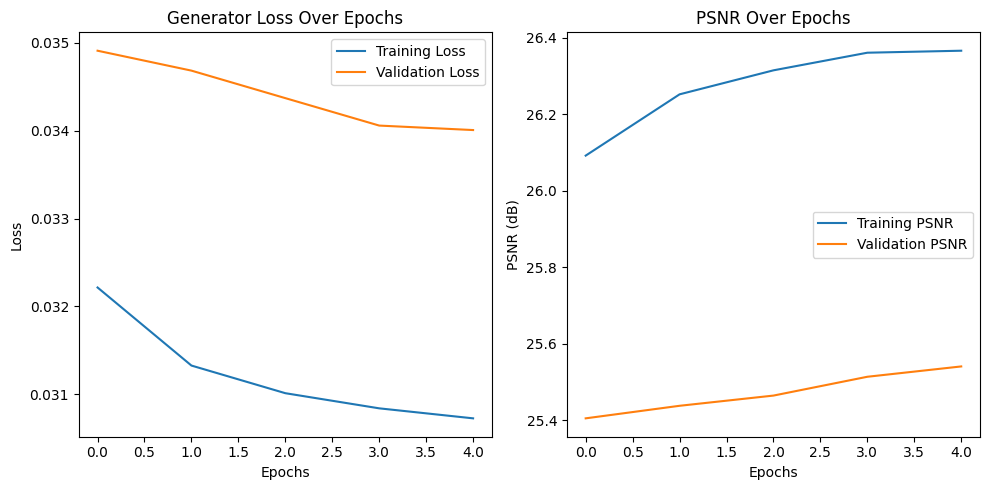

In [27]:
import matplotlib.pyplot as plt

# Plotting training and validation losses for generator
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_G, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting PSNR values for training and validation
plt.subplot(1, 2, 2)
plt.plot(train_psnrs, label='Training PSNR')
plt.plot(val_psnrs, label='Validation PSNR')
plt.title('PSNR Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()

plt.tight_layout()
plt.show()


In [28]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

generator.eval()  # Set the model to evaluation mode

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, mode='test'):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.file_names[idx]

# Define transformations for the test dataset
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to the input size required by your model
    transforms.ToTensor()
])

# Create the test dataset and data loader
test_dataset = TestDataset(
    root_dir='/kaggle/input/super-resolution-dataset/datasets_original/test/LQ',
    transform=test_transform,
    
)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Directory where you want to save the output images
output_directory = "/kaggle/working/super_resolved_images"
os.makedirs(output_directory, exist_ok=True)

# Generate super-resolved images
with torch.no_grad():
    for images, file_names in test_loader:
        images = images.to(device)
        sr_images = generator(images)
        
        # Convert the generated images back to PIL for saving
        sr_images = sr_images.cpu()
        for i, sr_image in enumerate(sr_images):
            sr_image_pil = transforms.ToPILImage()(sr_image)
            file_name = file_names[i]  # Correctly get the file name for each image in the batch
            
            # Save the super-resolved image
            sr_image_pil.save(os.path.join(output_directory, file_name))

In [29]:
import zipfile
import os

# Directory where super-resolved images are saved
output_directory = "/kaggle/working/super_resolved_images"
zip_filename = "/kaggle/working/super_resolved_images.zip"

# Create a zip file with all the super-resolved images
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(output_directory):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, os.path.join(output_directory, '..'))
            zipf.write(file_path, arcname)

print(f"Created zip file: {zip_filename}")


Created zip file: /kaggle/working/super_resolved_images.zip


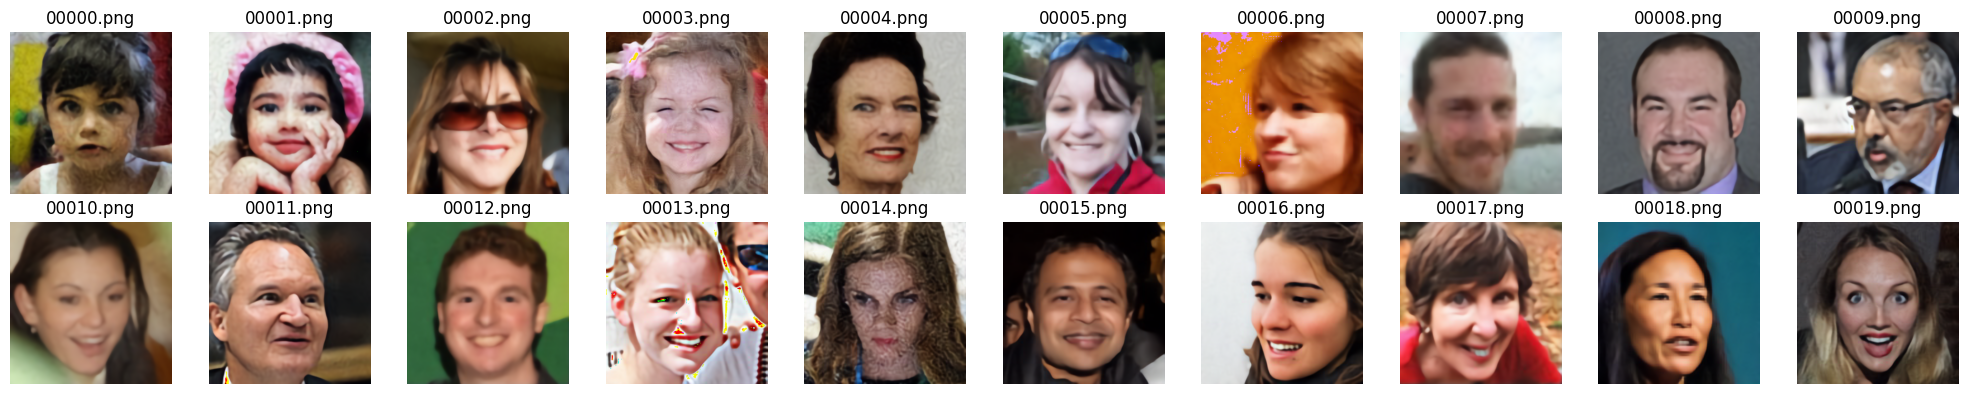

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Folder containing the images
folder_path = 'kaggle/working/super_resolved_images'

# Get a list of image filenames in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))]

# Sort files for consistency
image_files.sort()

# Maximum number of images to display
max_images = 20

# Create a figure with 2 rows
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the image files and the axes
for ax, img_filename in zip(axes, image_files[:max_images]):
    # Open and display the image
    img_path = os.path.join(folder_path, img_filename)
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')  # Hide axes
    ax.set_title(img_filename[:10])  # Set the title to the first 10 characters of the filename

# Adjust layout
plt.tight_layout()
plt.show()


This is average validation PSNR for 5 epochs. I used 20 epochs in report. you need to run all 20 epochs for checking

In [30]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

LQ_FILE = '/kaggle/input/super-resolution-dataset/datasets_original/val/LQ'

# Define the device for model computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the tensor to PIL Image conversion function
def tensor2PIL(tensor):
    """Convert a PyTorch tensor to a PIL Image."""
    return transforms.ToPILImage()(tensor)

# Define the PSNR calculation function
def psnr(img1, img2):
    """Compute PSNR between two images."""
    img1 = np.array(img1).astype(np.float32)
    img2 = np.array(img2).astype(np.float32)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255 / np.sqrt(mse))

# Initialize the PSNR value
psnr_val = 0

# Loop through low-quality image paths
for lq_image_path in os.listdir(LQ_FILE):
    lq_image_path = os.path.join(LQ_FILE, lq_image_path)
    lq_image = Image.open(lq_image_path).convert('RGB')
    hq_image = Image.open(lq_image_path.replace("LQ", "GT")).convert('RGB')
    
    # Convert image to tensor, forward through the generator, and convert back to PIL Image
    output = generator(F.to_tensor(lq_image).unsqueeze(0).to(device))
    output_image = tensor2PIL(output.squeeze(0).cpu())
    
    # Calculate and accumulate PSNR
    psnr_val += psnr(hq_image, output_image)

# Assuming the number of images is not zero
num_images = len(os.listdir(LQ_FILE))
average_psnr = psnr_val / num_images
print(f"Average PSNR: {average_psnr}")


Average PSNR: 25.393482707584
